# Breast Cancer Prediction 
**Team Members**
1. Deepika Kar - 12001032020
2. Kaavya Saxena - 09201032020
3. Khushi Khokhar - 13201032020

# Importing  python librarires 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time


# Importing data

In [2]:
df = pd.read_csv(r'Breast_cancer_data.csv')

# Data Analysis

(569, 6)
counting  non-null values..
total non-null values in columns:- 0      6
1      6
2      6
3      6
4      6
      ..
564    6
565    6
566    6
567    6
568    6
Length: 569, dtype: int64
['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness', 'diagnosis']


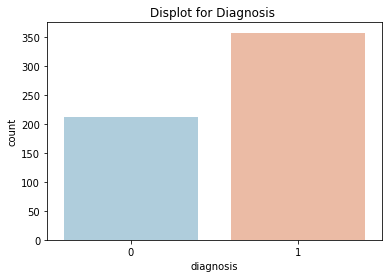

In [3]:
print(df.shape)

df.describe()
df.isnull().sum()
print("counting  non-null values..")
print("total non-null values in columns:-",df.count(1))
cols = list(df.columns)
print(cols)
sns.countplot(x='diagnosis', data=df, palette='RdBu_r')
plt.title('Displot for Diagnosis ')
plt.show()

# Data Visualization and Pre Processing 

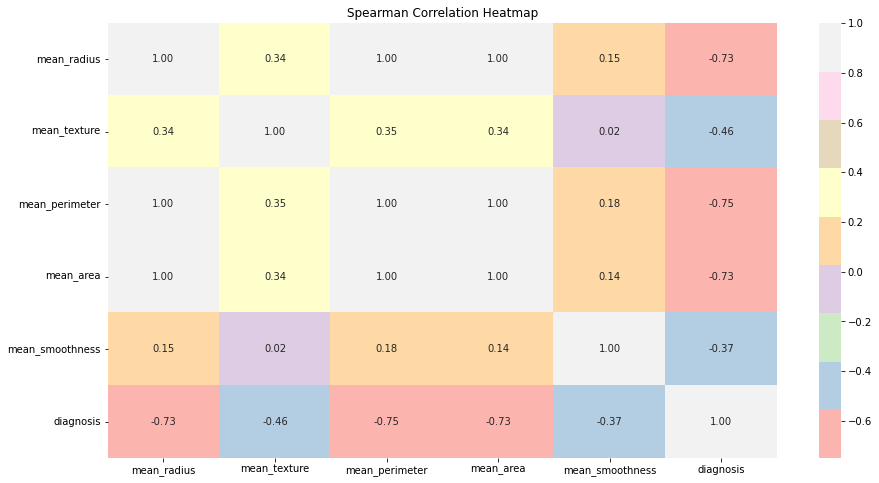

In [4]:
#heatmap for all the parameters of diagnosis
corr = df.corr(method = 'spearman')  
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Pastel1')
plt.title('Spearman Correlation Heatmap')
plt.show()

<Figure size 720x720 with 0 Axes>

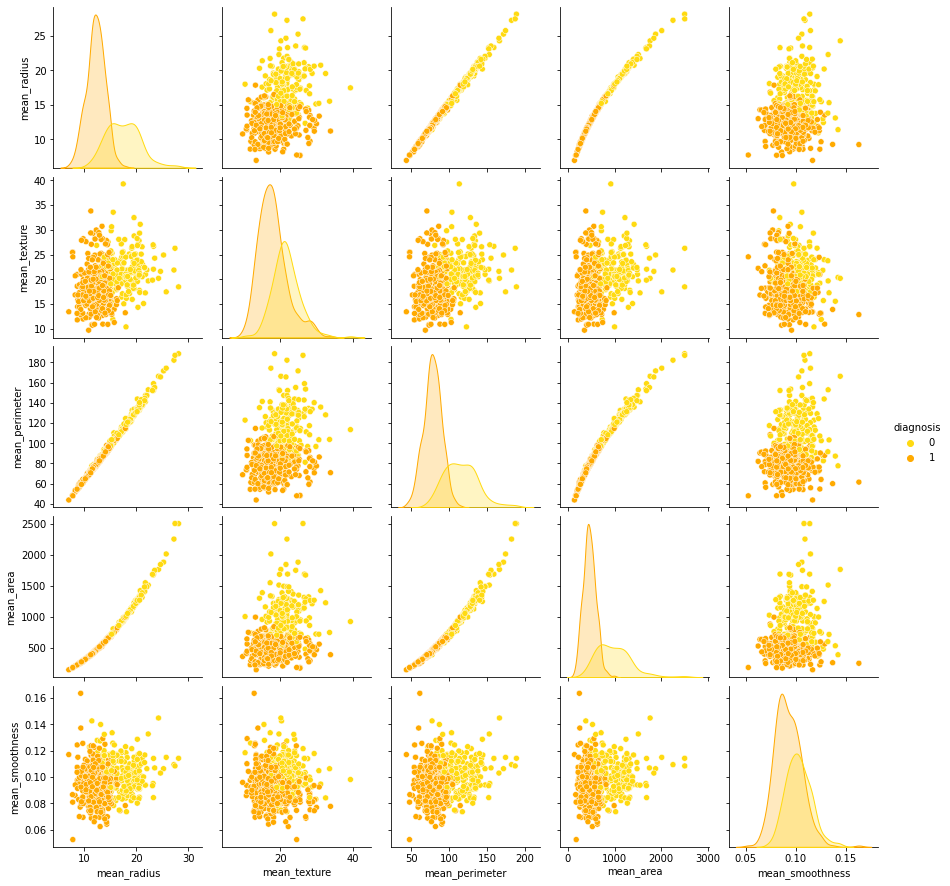

In [5]:
figure = plt.figure(figsize=(10,10))   # plotting for all the parameters 
sns.pairplot(df, hue='diagnosis', palette='Wistia')
plt.show()

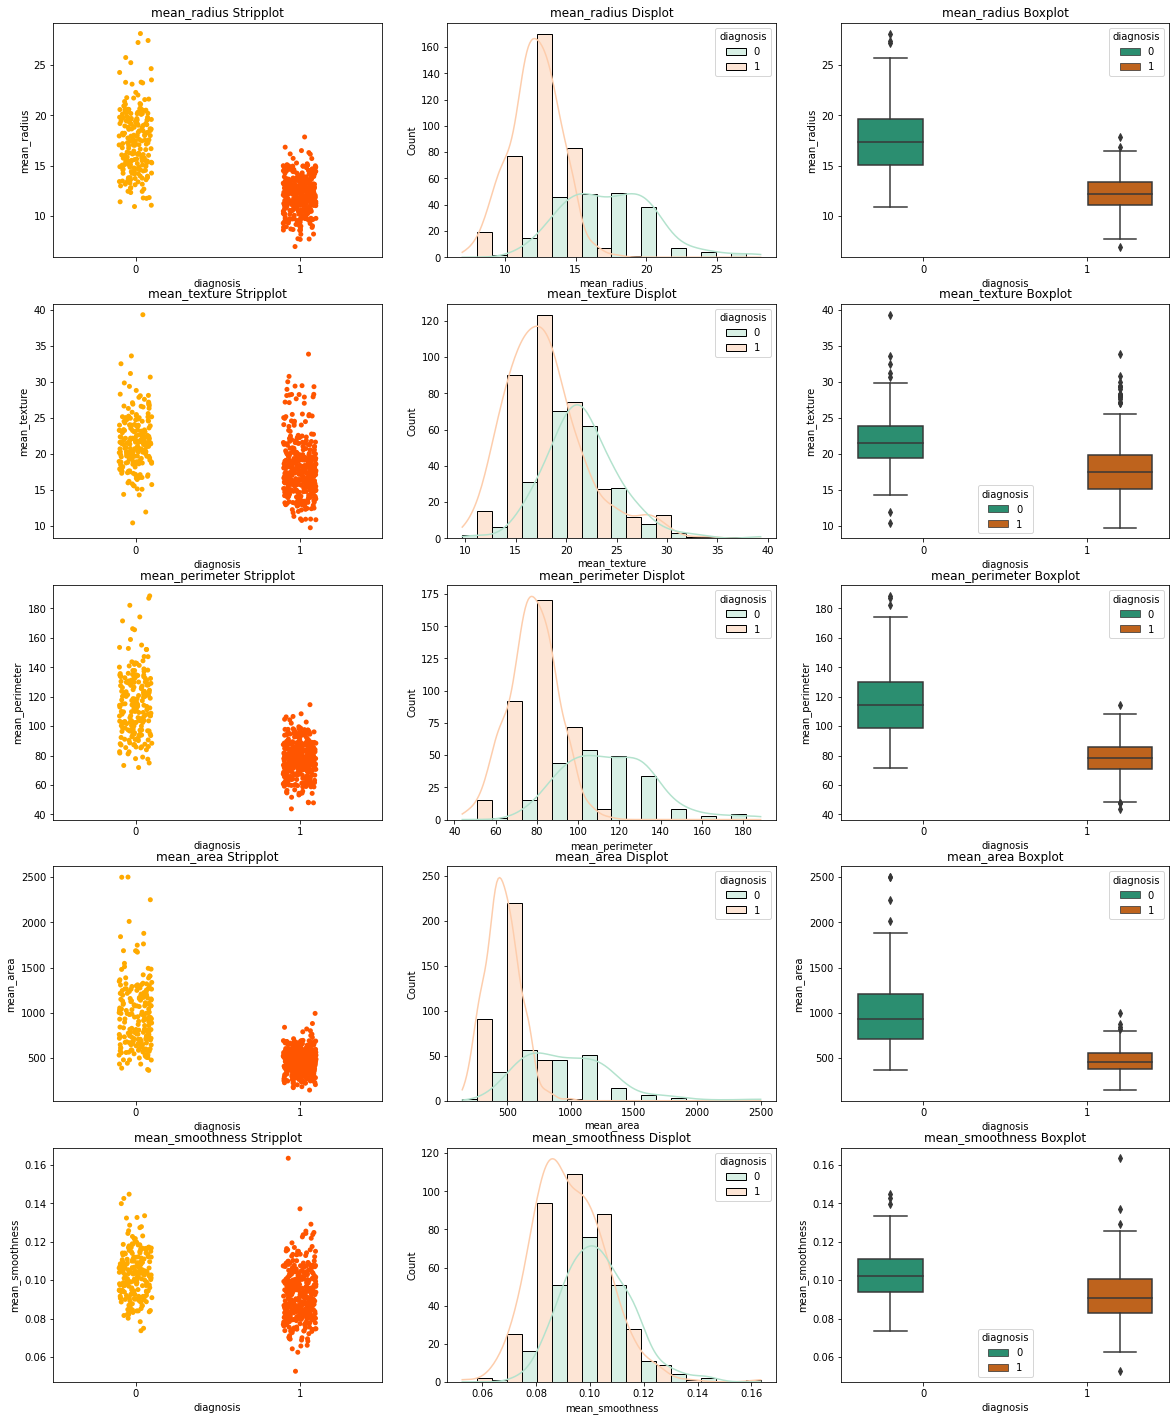

In [6]:
fig, axes = plt.subplots(5, 3, figsize=(20,25))
for i, col in zip(range(5), cols):
    sns.stripplot(ax=axes[i][0], x='diagnosis', y=col, data=df, palette='autumn_r', jitter=True)
    axes[i][0].set_title(f'{col} Stripplot')
    sns.histplot(ax=axes[i][1], x=col, data=df, kde=True, bins=10, palette='Pastel2', hue='diagnosis', multiple='dodge')
    axes[i][1].set_title(f'{col} Displot')
    sns.boxplot(ax=axes[i][2], x='diagnosis', y=col, data=df, palette='Dark2', hue='diagnosis')
    axes[i][2].set_title(f'{col} Boxplot')

In [7]:
def outlier_limits(df, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_limits(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit
    
for variable in cols:
    replace_with_limits(df, variable)

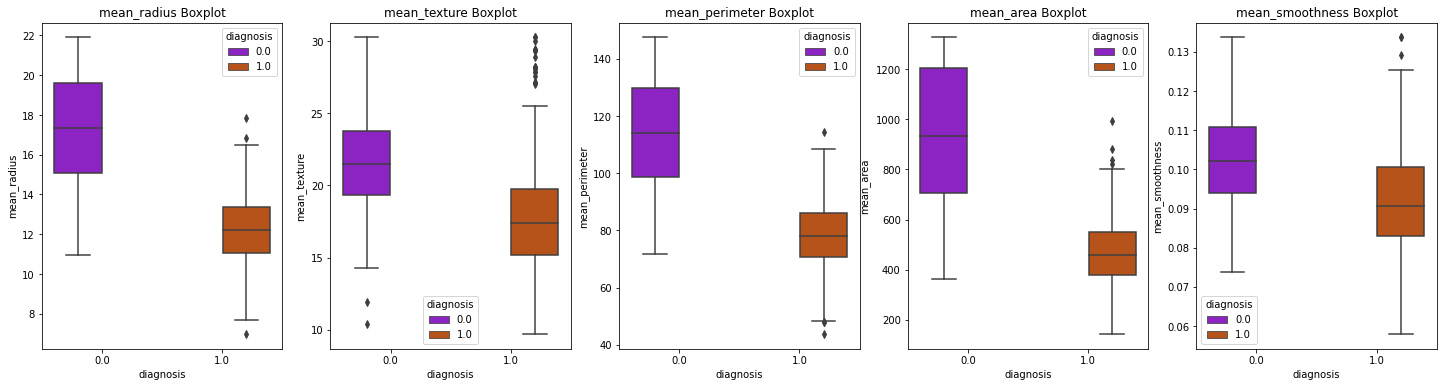

In [8]:
# showing box plot for all the parameters 
fig, axes = plt.subplots(1, 5, figsize=(25,6))
for i, col in zip(range(5), cols):
    sns.boxplot(ax=axes[i], x='diagnosis', y=col, data=df, palette='gnuplot', hue='diagnosis')
    axes[i].set_title(f'{col} Boxplot')


**PREPROCESSING**

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=cols)
df_scaled.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,0.737918,0.032627,0.761873,0.724975,0.798006,0.0
1,0.910852,0.392501,0.859264,0.999746,0.353473,0.0
2,0.851867,0.561967,0.831300,0.895756,0.681788,0.0
3,0.297540,0.519601,0.325828,0.205107,1.000000,0.0
4,0.892084,0.225469,0.880478,0.975228,0.558967,0.0
5,0.366580,0.291697,0.373945,0.282043,0.922147,0.0
6,0.755346,0.500122,0.731016,0.757947,0.484086,0.0
7,0.451036,0.541514,0.447519,0.367264,0.804609,0.0
8,0.403445,0.589725,0.421484,0.318143,0.915544,0.0
9,0.367250,0.697833,0.387445,0.281028,0.800647,0.0


In [10]:
X= df_scaled.iloc[:,3:4]
y = df_scaled['diagnosis']
X.head(10)

,mean_area
0,0.724975
1,0.999746
2,0.895756
3,0.205107
4,0.975228
5,0.282043
6,0.757947
7,0.367264
8,0.318143
9,0.281028


In [11]:
#training and testing the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 

In [12]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1':'f1'}

In [13]:
def fit(clf, params, cv=10, X_train=X_train, y_train=y_train):
    grid = GridSearchCV(clf, params, cv=KFold(n_splits=cv), n_jobs=1, verbose=1, return_train_score=True, scoring=scoring, refit='f1') 
    grid.fit(X_train, y_train)
    return grid

def make_predictions(model, X_test=X_test):
    return model.predict(X_test)

def best_scores(model):
  best_mean_f1 = max(list(model.cv_results_['mean_test_f1']))
  mean_f1_index = list(model.cv_results_['mean_test_f1']).index(best_mean_f1)
  print(f'The best parameters are: {model.best_params_}')
  print('Mean Test Cross Validation Scores for different metrics: (corresponding to best mean f1)')
  print('The best score that we get is (Accuracy): ' + str(model.cv_results_['mean_test_accuracy'][mean_f1_index]))
  print('The best score that we get is (Precision): ' + str(model.cv_results_['mean_test_precision'][mean_f1_index]))
  print(f'The best score that we get is (F1 Score): {best_mean_f1}')
  return None
def plot_confusion_matrix(y_pred):
    print('00: True Negatives\n01: False Positives\n10: False Negatives\n11: True Positives\n')
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.matshow(conf_matrix, cmap='GnBu', alpha=0.75)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large') 
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('Actuals', fontsize=20)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()
    return None
def check_scores(y_pred):
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    return None 

In [14]:
import warnings
warnings.filterwarnings('always')

**LOGISTIC REGRESSION MODEL**

In [15]:
lr_params = {'C':[0.001,.009,0.01,.09,1,5,10,25], 'penalty':['l1', 'l2']} #lasso and ridge regression
lr_clf = LogisticRegression(solver='saga', max_iter=5000)
lr_model = fit(lr_clf, lr_params)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [16]:
best_scores(lr_model)

The best parameters are: {'C': 5, 'penalty': 'l2'}
Mean Test Cross Validation Scores for different metrics: (corresponding to best mean f1)
The best score that we get is (Accuracy): 0.8898671096345515
The best score that we get is (Precision): 0.8736434484401506
The best score that we get is (F1 Score): 0.91612821888844


In [17]:
lr_y_pred = make_predictions(lr_model)
check_scores(lr_y_pred)

Precision: 0.879
Accuracy: 0.895
F1 Score: 0.921


**PLOTTING OF CONFUSION MATRIX FOR LINEAR REGRESSION MODEL**

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



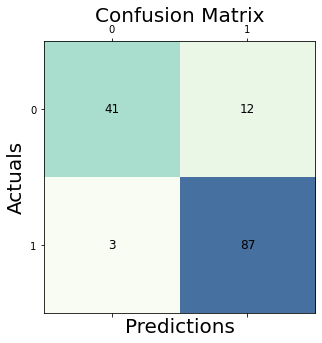

In [18]:
plot_confusion_matrix(lr_y_pred)

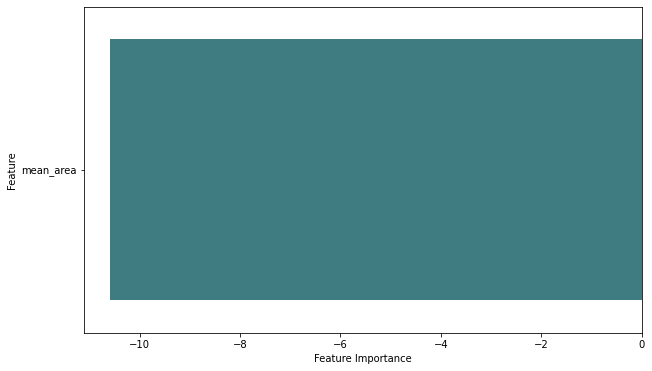

In [19]:
lr_feature_scores = lr_model.best_estimator_.coef_[0].tolist()
lr_fi = pd.DataFrame({'Feature': X.columns , 'Feature Importance': lr_feature_scores})
plt.figure(figsize=(10,6))
sns.barplot(x='Feature Importance', y='Feature', data=lr_fi, palette='crest', )
plt.show()

**LINEAR DISCRIMINANT LEARNING (LDA)**

In [20]:
lda_params = {'solver': ['svd', 'eigen']}
lda_clf =LDA()
lda_model = fit(lda_clf, lda_params)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [21]:
best_scores(lda_model)

The best parameters are: {'solver': 'svd'}
Mean Test Cross Validation Scores for different metrics: (corresponding to best mean f1)
The best score that we get is (Accuracy): 0.8710409745293466
The best score that we get is (Precision): 0.8414402236727287
The best score that we get is (F1 Score): 0.9043057922054448


In [22]:
lda_y_pred = make_predictions(lda_model)
check_scores(lda_y_pred)

Precision: 0.853
Accuracy: 0.874
F1 Score: 0.906


**Plotting of confusion matrix for LDA**

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



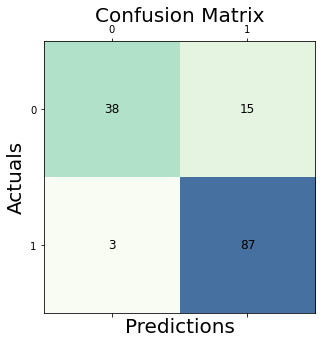

In [23]:
plot_confusion_matrix(lda_y_pred)

**SUPPORT VECTOR MACHINE (SVM)**

In [24]:
svm_params = {'C':[1,10,100,1000], 'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
svm_clf = SVC()
svm_model = fit(svm_clf, svm_params)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


In [25]:
best_scores(svm_model)

The best parameters are: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Mean Test Cross Validation Scores for different metrics: (corresponding to best mean f1)
The best score that we get is (Accuracy): 0.8875415282392026
The best score that we get is (Precision): 0.8733971430214315
The best score that we get is (F1 Score): 0.9142528407880166


In [26]:
svm_y_pred = make_predictions(svm_model)
check_scores(svm_y_pred)

Precision: 0.879
Accuracy: 0.895
F1 Score: 0.921


**Plotting Confusion Matrix For SVM**

00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



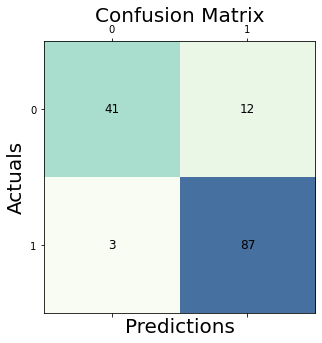

In [27]:
plot_confusion_matrix(svm_y_pred)

**K- NEAREST NEIGHBOURS (KNNs)**

In [28]:
knns_params = {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance'], 
               'metric': ['euclidean', 'manhattan']}
knns_clf = KNeighborsClassifier()
knns_model = fit(knns_clf, knns_params)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

In [29]:
best_scores(knns_model)

The best parameters are: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Mean Test Cross Validation Scores for different metrics: (corresponding to best mean f1)
The best score that we get is (Accuracy): 0.8875415282392026
The best score that we get is (Precision): 0.8710224806982152
The best score that we get is (F1 Score): 0.9146086396949858


In [30]:
knns_y_pred = make_predictions(knns_model)
check_scores(knns_y_pred)

Precision: 0.879
Accuracy: 0.895
F1 Score: 0.921


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



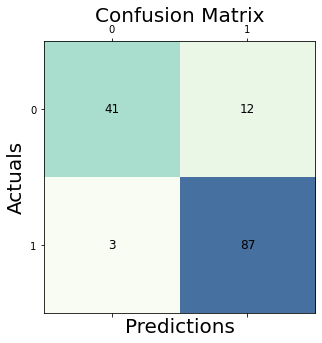

In [31]:
plot_confusion_matrix(knns_y_pred)

#CONCLUSION

1. Three classification models; LDA, SVM and KNNs were used to clasify the data.
2. Hypertuning was done to get the best result.
3. Variables were scaled for KNN, SVM and LDA models.  
4. Each model provides a high accuracy with Linear Discriminative Analysis being the lowest with 86% and all the other model provide an accuracy of 88%.

 










# SELECTION OF KNNs MODEL

1. K-nearest neighbors(KNN) is a non-parametric method used for classification and regression. It is one of the most easy machine learning technique used. It is a lazy learning model, with local approximation.

2. Basic Theory :
The basic logic behind KNN is to explore your neighborhood, assume the test datapoint to be similar to them and derive the output. In KNN, we look for k neighbors and come up with the prediction.


3. Advantages :
* Easy and simple machine learning model.
* Few hyperparameters to tune.
* KNN is better than SVM. SVM outperforms KNN when there are large features and lesser training data.


4. KNN is a completely non-parametric approach: no assumptions are made about the shape of the decision boundary.
Therefore, we can expect KNN to dominate LDA and logistic regression when the decision boundary is highly non-linear.
